In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
from tqdm import tqdm
from load import get_btch
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftFly3D/openmonkey/OMS_Dataset/', # Change data path here
             'out_dir'        : './out_test/', 
             'train_subjects' : ["7"],
             'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}
plt.style.use('dark_background')

# Load Data

In [2]:
# takes around a minute
train_2d, train_3d, train_keys = list(), list(), list()
for btch in par_train["train_subjects"]:
    Data, _ = get_btch(btch)
    for idx, (k,v) in enumerate(Data.items()):
        train_2d.append(Data[k]["points2d"])
        train_3d.append(Data[k]["points3d"])
        train_keys.append(k)

test_2d, test_3d, test_keys = list(), list(), list()
for btch in par_train["test_subjects"]:
    Data, _ = get_btch(btch)
    for idx, (k,v) in enumerate(Data.items()):
        test_2d.append(Data[k]["points2d"])
        test_3d.append(Data[k]["points3d"])
        test_keys.append(k)

train_2d, train_3d = np.stack(train_2d), np.stack(train_3d)
test_2d, test_3d = np.stack(test_2d), np.stack(test_3d)

#remove points with with large variance for easier training
good_ind = np.where((train_2d.reshape(train_2d.shape[0], -1)).std(axis=1) < 1000)[0]
train_2d = train_2d[good_ind]
train_3d = train_3d[good_ind]

# l2 normalization
train_2d /= np.linalg.norm(train_2d, axis=(-1,-2), keepdims=True)
test_2d /= np.linalg.norm(test_2d, axis=(-1,-2), keepdims=True)

In [33]:
import pickle
train_2d_l = pickle.load(open('train2d_proj_then_bln_no_missing_camera_marker.pkl', 'rb'))
train_2d_l2 = pickle.load(open('train2d_proj_then_bln_no_missing_camera.pkl', 'rb'))

In [ ]:
pickle.dump(train_2d, open('train2d_proj_then_bln_no_missing_camera_marker_norm.pkl', 'wb'))
pickle.dump(train_3d, open('train3d_proj_then_bln_no_missing_camera_marker_norm.pkl', 'wb'))

In [3]:
import pickle
train_2d =  pickle.load(open('train2d_proj_then_bln_no_missing_camera_marker_norm.pkl', 'rb'))
train_3d = pickle.load(open('train3d_proj_then_bln_no_missing_camera_marker_norm.pkl', 'rb'))

# Train Model

In [3]:
from liftpose.main import train_np as lp3d_train

lp3d_train(train_2d=train_2d, test_2d=test_2d, 
           train_3d=train_3d, test_3d=test_3d,
           root=par['roots'][0], target_sets=par['target_sets'], out_dir=par['out_dir'],
           training_kwargs={"epochs":100,  "lr_decay":10000, "dropout":0.1})

[main.py:252]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/out_test/stat_2d.pth.tar.
[main.py:271]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/out_test/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out_test',
    'drop_input': 0.0,
    'dropout': 0.1,
    'epochs': 100,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 10000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out_test',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out_test',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[ma

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  0.73647|: 100%|██████████| 222/222 [00:03<00:00, 66.97it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.22053 | Loss Train  0.40286|: 100%|██████████| 222/222 [00:03<00:00, 68.06it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.16474 | Loss Train  0.31592|: 100%|██████████| 222/222 [00:03<00:00, 67.89it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.17737 | Loss Train  0.25383|: 100%|██████████| 222/222 [00:03<00:00, 70.79it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.22062 | Loss Train  0.21587|: 100%|██████████| 222/222 [00:03<00:00, 68.12it/s]
Epoch 005 | LR  0.00100 | Loss Test  0.20535 | Loss Train  0.18565|: 100%|██████████| 222/222 [00:03<00:00, 71.91it/s]
Epoch 006 | LR  0.00100 | Loss Test  0.16753 | Loss Train  0.17067|: 100%|██████████| 222/222 [00:03<00:00, 69.22it/s]
Epoch 007 | LR  0.00100 | Loss Test  0.19242 | Loss Train  0.15537|: 100%|██████████| 222/222 [00:03<00:00, 69.94it/s]
Epoch 008 | LR  0.00100 | Loss Test  0.14545 | L

KeyboardInterrupt: 

In [4]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(data, stat_2d, stat_3d)

[main.py:409]:INFO:starting testing in path: ./out_test/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.27M
[lift.py:66]:INFO:loading ckpt from './out_test/ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 10 | err: 0.0782314814697834)
[lift.py:110]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/openmonkey/out_test/test_results.pth.tar


# Violin Plots

/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(0.0, 15.0)

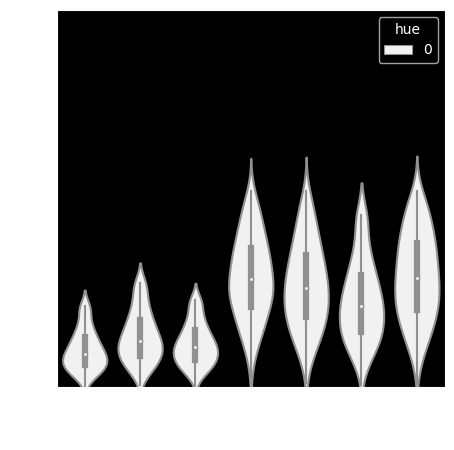

In [5]:
%matplotlib inline
from liftpose.plot import violin_plot
plt.figure(figsize=(5,5), dpi=100)

# concat left and right limbs
names = par_data["vis"]["names"]
r = ['Head', 'Nose', 'RShoulder', 'Hip',  'RKnee', 'RFoot', 'RHand']
l = ['Head', 'Nose', 'Shoulder',  'Hip',  'Knee', 'Foot', 'Hand']
r_indices = [names.index(r_) for r_ in r]
l_indices = [names.index(l_) for l_ in l]
test_3d_gt_ord = np.concatenate([test_3d_gt[:,r_indices], test_3d_gt[:, l_indices]])
test_3d_pred_ord = np.concatenate([test_3d_pred[:,r_indices], test_3d_pred[:, l_indices]])

violin_plot(plt.gca(), test_3d_gt_ord, test_3d_pred_ord, test_keypoints=np.ones_like(test_3d_pred_ord), joints_name=l, body_length=2.21, units='?')
plt.ylim([0,15])

# Plot single video frame

In [7]:
Data, cameras = get_btch('9')

2607 ('9', 12240, '18260989')


NameError: name 'mcol' is not defined

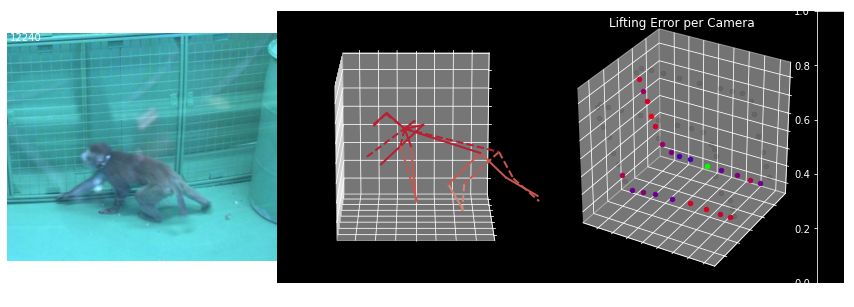

In [8]:
%matplotlib inline
from liftpose.plot import plot_pose_3d
from plot_util import *
from matplotlib.ticker import NullFormatter

# define eaxis
fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])


# load image and plot
idx = np.random.randint(test_3d_pred.shape[0])
k = list(Data.keys())[idx]
print(idx, k)

btch, img_id, cam = k
img_name = '/data/LiftFly3D/openmonkey/OMS_Dataset/Images/batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg'
ax2d.imshow(plt.imread(img_name))
ax2d.text(x=5, y=15, s=f"{img_id}")

ax3d.view_init(elev=-75, azim=-90)
plot_pose_3d(ax=ax3d, tar=test_3d_gt[idx],
             pred=test_3d_pred[idx],
             bones=par_data["vis"]["bones"], 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"], 
             normalize=True)

mi, ma = 0.04, 0.2
err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
plot_cameras_err(ax=ax3d_cameras, err=err, mi=0.04, ma=0.2, cameras=cameras, curr_camera=cam)

ax2d.axis('off')
lim = [-0.75, 0.75]
ax3d.set_xlim(lim)
ax3d.set_ylim(lim)
ax3d.set_zlim(lim)
# remove ticks
ax3d.xaxis.set_major_formatter(NullFormatter())
ax3d.yaxis.set_major_formatter(NullFormatter())
ax3d.zaxis.set_major_formatter(NullFormatter())
ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

# setting titles
ax3d_cameras.set_title('Lifting Error per Camera')
cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Percentage of Body Length (%)',fontsize=13)